<a href="https://colab.research.google.com/github/kandi00/Objectivity-detection/blob/main/Github_Subj_database_TextClassificationWithBERT_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get GPU type

In [ ]:
!nvidia-smi

Sun Jun 16 18:38:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              35W /  70W |   3093MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Dataset

Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import train and test data

In [ ]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('/content/drive/My Drive/Disszertacio/subj_train.tsv', sep = '\t')
df_test = pd.read_csv('/content/drive/My Drive/Disszertacio/subj_test.tsv', sep = '\t')

Analyze data

In [ ]:
df_train.head()
df_test.head()

print('Total number of sentences: {}'.format(len(df_train)))
print(40*'-')
print('Split by label:')
print(df_train["label"].value_counts())
print(40*'-')
nr_categories = len(df_train["label"].unique())
print("Number of labels: {n}".format(n=nr_categories))

print('Total number of sentences: {}'.format(len(df_test)))
print(40*'-')
print('Split by label:')
print(df_test["label"].value_counts())
print(40*'-')
nr_categories = len(df_test["label"].unique())
print("Number of labels: {n}".format(n=nr_categories))

n=100
print('Label: ', df_test['label'][n])
print(100*'-')
print('Text:')
print(df_test['text'][n])

Total number of sentences: 8000
----------------------------------------
Split by label:
label
1    4000
0    4000
Name: count, dtype: int64
----------------------------------------
Number of labels: 2
Total number of sentences: 2000
----------------------------------------
Split by label:
label
1    1000
0    1000
Name: count, dtype: int64
----------------------------------------
Number of labels: 2
Label:  1
----------------------------------------------------------------------------------------------------
Text:
greengrass has delivered an undoubted stylistic tour-de-force , and has managed elements such as sound and cinematography with skill


Get the train data

In [ ]:
X_train = df_train['text']
y_train = np.unique(df_train['label'], return_inverse=True)[1]
print(len(X_train))
print(X_train)
print(len(y_train))
print(y_train)

X_test = df_test['text']
y_test = np.unique(df_test['label'], return_inverse=True)[1]
print(len(X_test))
print(X_test)
print(len(y_test))
print(y_test)

8000
0       smart and alert , thirteen conversations about...
1       color , musical bounce and warm seas lapping o...
2       it is not a mass-market entertainment but an u...
3       a light-hearted french film about the spiritua...
4       my wife is an actress has its moments in looki...
                              ...                        
7995    as they make their way to the city from suburb...
7996    five hours ago the " t virus " was " accidenta...
7997    with this relation the characters will discove...
7998      an art whose medium is one of flesh and bone . 
7999    however , once jason realizes what freddy has ...
Name: text, Length: 8000, dtype: object
8000
[1 1 1 ... 0 0 0]
2000
0       uno de los policiales m�s interesantes de los ...
1        . . . is there a deeper , more direct connect...
2       possibly not since grumpy old men have i heard...
3       hollywood has taken quite a nosedive from alfr...
4       if swimfan does catch on , it may be because t...

In [ ]:
count_of_zeros = np.sum(y_test == 0)
count_of_ones = np.sum(y_test == 1)
print(count_of_zeros)
print(count_of_ones)

count_of_zeros = np.sum(y_train == 0)
count_of_ones = np.sum(y_train == 1)
print(count_of_zeros)
print(count_of_ones)

1000
1000
4000
4000


Prepare the dataset

Instantiate the BERT tokenizer

In [ ]:
from transformers import logging, AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
import torch

X_train_list = X_train.to_list()
X = tokenizer(X_train_list, padding='max_length', max_length = 256, truncation=True, return_tensors='pt')["input_ids"]

y_train_list = y_train.tolist()
y = torch.Tensor(y_train_list).long()

X_test_list = X_test.to_list()
X_test = tokenizer(X_test_list, padding='max_length', max_length = 256, truncation=True, return_tensors='pt')["input_ids"]

y_test_list = y_test.tolist()
y_test = torch.Tensor(y_test_list).long()

Split the dataset into training, test and validation data.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y_train)

print('#train_samples:', len(y_train))
print('#test_samples:', len(y_test))
print('#val_samples:', len(y_val))

#train_samples: 7200
#test_samples: 2000
#val_samples: 800


In [ ]:
from torch.utils.data import Dataset, DataLoader
class SubjDataset(Dataset):
    """Custom-built Subj dataset"""

    def __init__(self, X, y):
        """
        Args:
            X, y as Torch tensors
        """
        self.X_train = X
        self.y_train = y


    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]

In [ ]:
train_data_pt = SubjDataset(X=X_train, y=y_train)
test_data_pt = SubjDataset(X=X_test, y=y_test)
val_data_pt = SubjDataset(X=X_val, y=y_val)

In [ ]:
train_loader_pt = DataLoader(train_data_pt, batch_size=16)
test_loader_pt = DataLoader(test_data_pt, batch_size=16)
val_loader_pt = DataLoader(val_data_pt, batch_size=16)

# Build the Model

Get the pretrained model

In [ ]:
dbert_pt = AutoModel.from_pretrained('distilbert-base-uncased')

In [ ]:
# Create a sample of size 5 from the training data
sample = X_train[0:5]
print('Object type: ', type(dbert_pt(sample)))
print('Output format (shape): ',dbert_pt(sample)[0].shape)
print('Output used as input for the classifier (shape): ', dbert_pt(sample)[0][:,0,:].shape)

Object type:  <class 'transformers.modeling_outputs.BaseModelOutput'>
Output format (shape):  torch.Size([5, 256, 768])
Output used as input for the classifier (shape):  torch.Size([5, 768])


Create the MY-BERT model

In [ ]:
from torch import nn
num_classes = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

class DistilBertClassification(nn.Module):
     def __init__(self):
         super(DistilBertClassification, self).__init__()
         self.dbert = dbert_pt
         self.num_classes = 2
         self.dropout = nn.Dropout(p=0.5)
         self.linear = nn.Linear(dbert_pt.config.hidden_size, num_classes)
         # BERT model is trainable
         for param in dbert_pt.parameters():
           param.requires_grad_(True)

     def forward(self, x):
         x = self.dbert(input_ids=x)
        #  print(f"Size after BERT model: {x['last_hidden_state'].size()}")
         x = x["last_hidden_state"][:,0,:]
        #  print(f"Size after selecting the [CLS] token: {x.size()}")
         x = self.dropout(x)
        #  print(f"Size after dropout: {x.size()}")
         x = self.linear(x)
        #  print(f"Size after linear layer: {x.size()}")
         return x
model_pt = DistilBertClassification().to(device)

In [ ]:
print(model_pt)

DistilBertClassification(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1

Get the number of parameters (trainable and non-trainable)

In [ ]:
total_params = sum(p.numel() for p in model_pt.parameters())
total_params_trainable = sum(p.numel() for p in model_pt.parameters() if p.requires_grad)
print("Number of parameters: ", total_params)
print("Number of trainable parameters: ", total_params_trainable)

Number of parameters:  66364418
Number of trainable parameters:  66364418


# Train the Model

In [ ]:
epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_pt.parameters(), lr=1e-5, weight_decay=0.01)

In [ ]:
import torch
from tqdm import tqdm
from datetime import datetime

# Define the dictionary "history" that will collect key performance indicators during training
history = {
    "epoch": [],
    "train_loss": [],
    "valid_loss": [],
    "train_accuracy": [],
    "valid_accuracy": [],
}

# Measure time for training
start_time = datetime.now()

# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pt.to(device)

# Loop on epochs
for e in range(epochs):

    # Set mode in train mode
    model_pt.train()

    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # Loop on batches
    for X, y in tqdm(train_loader_pt):
        # Move data to GPU
        X, y = X.to(device), y.to(device)

        # Get prediction & loss
        prediction = model_pt(X)
        loss = criterion(prediction, y)

        # Adjust the parameters of the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        prediction_index = prediction.argmax(dim=1)
        train_correct += (prediction_index == y).sum().item()
        train_total += y.size(0)

    train_accuracy = train_correct / train_total

    # Calculate the loss on the validation data after each epoch
    model_pt.eval()
    valid_loss = 0.0
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for X, y in val_loader_pt:
            # Move data to GPU
            X, y = X.to(device), y.to(device)

            prediction = model_pt(X)
            loss = criterion(prediction, y)

            valid_loss += loss.item()

            prediction_index = prediction.argmax(dim=1)
            valid_correct += (prediction_index == y).sum().item()
            valid_total += y.size(0)

    valid_accuracy = valid_correct / valid_total

    # Populate history
    history["epoch"].append(e + 1)
    history["train_loss"].append(train_loss / len(train_loader_pt))
    history["valid_loss"].append(valid_loss / len(val_loader_pt))
    history["train_accuracy"].append(train_accuracy)
    history["valid_accuracy"].append(valid_accuracy)

    print(f'Epoch {e + 1} \t\t Training Loss: {train_loss / len(train_loader_pt) :10.3f} \t\t Validation Loss: {valid_loss / len(val_loader_pt) :10.3f}')
    print(f'\t\t Training Accuracy: {train_accuracy :10.3%} \t\t Validation Accuracy: {valid_accuracy :10.3%}')

# Measure time for training
end_time = datetime.now()
training_time_pt = (end_time - start_time).total_seconds()

100%|██████████| 450/450 [02:56<00:00,  2.55it/s]


Epoch 1 		 Training Loss:      0.256 		 Validation Loss:      0.111
		 Training Accuracy:    88.125% 		 Validation Accuracy:    95.625%


100%|██████████| 450/450 [02:55<00:00,  2.56it/s]


Epoch 2 		 Training Loss:      0.095 		 Validation Loss:      0.116
		 Training Accuracy:    96.694% 		 Validation Accuracy:    95.625%


100%|██████████| 450/450 [02:55<00:00,  2.57it/s]


Epoch 3 		 Training Loss:      0.053 		 Validation Loss:      0.114
		 Training Accuracy:    98.347% 		 Validation Accuracy:    96.625%


100%|██████████| 450/450 [02:55<00:00,  2.57it/s]


Epoch 4 		 Training Loss:      0.034 		 Validation Loss:      0.105
		 Training Accuracy:    99.014% 		 Validation Accuracy:    97.250%


100%|██████████| 450/450 [02:55<00:00,  2.57it/s]


Epoch 5 		 Training Loss:      0.022 		 Validation Loss:      0.114
		 Training Accuracy:    99.306% 		 Validation Accuracy:    97.250%


In [ ]:
def calculate_metrics(valid_labels, predicted_labels):
    # Calculate accuracy
    accuracy = sum(1 for v, p in zip(valid_labels, predicted_labels) if v == p) / len(valid_labels)

    # Calculate true positives, false positives, and false negatives
    true_positives = sum(1 for v, p in zip(valid_labels, predicted_labels) if v == p and v == 1)
    false_positives = sum(1 for v, p in zip(valid_labels, predicted_labels) if v != p and p == 1)
    false_negatives = sum(1 for v, p in zip(valid_labels, predicted_labels) if v != p and v == 1)

    # Calculate precision
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0

    # Calculate recall
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1_score, true_positives, false_positives, false_negatives

Test the model

In [ ]:
model_pt.eval()
test_loss = 0.0
test_accuracy = []

all_labels = []
all_predictions = []

with torch.no_grad():
    for X, y in test_loader_pt:  # assuming you have a test_loader_pt for test data
        # Move data to GPU
        X, y = X.to(device), y.to(device)

        prediction = model_pt(X)
        loss = criterion(prediction, y)

        test_loss += loss.item()

        prediction_index = prediction.argmax(axis=1)
        accuracy = (prediction_index == y).float()
        test_accuracy.extend(accuracy.cpu().numpy())

        all_labels.extend(y.cpu().numpy())
        all_predictions.extend(prediction_index.cpu().numpy())

# Calculate metrics
accuracy, precision, recall, f1_score, true_positives, false_positives, false_negatives = calculate_metrics(all_labels, all_predictions)

# Print results
print(f'Test Loss: {test_loss / len(test_loader_pt) :10.3f}')
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1_score)
print("Test false_positives:", false_positives)
print("Test false_negatives:", false_negatives)

Test Loss:      0.151
Test Accuracy: 0.9505
Test Precision: 0.9455984174085065
Test Recall: 0.956
Test F1 Score: 0.9507707608155148
Test false_positives: 55
Test false_negatives: 44


Create some plots

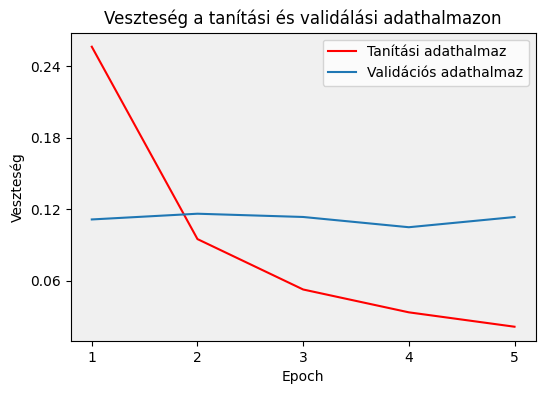

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator


fig, ax = plt.subplots(figsize=(6, 4))
ax.set_facecolor('#f0f0f0')
ax.set(title='Veszteség a tanítási és validálási adathalmazon')
ax.plot(history['epoch'], history['train_loss'], label='Tanítási adathalmaz', color = 'red')
ax.plot(history['epoch'], history['valid_loss'], label='Validációs adathalmaz')
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax.set_xlabel('Epoch')
ax.set_ylabel('Veszteség')
ax.legend(loc="upper right")

plt.show()

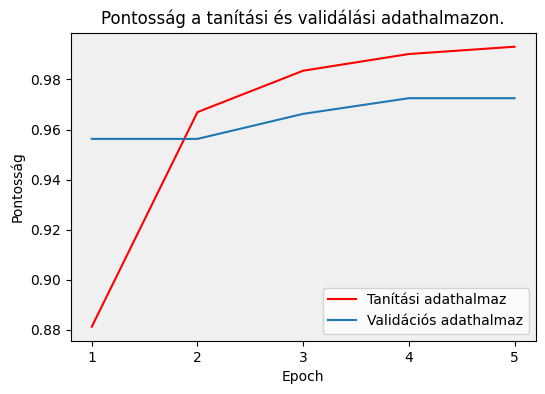

{'epoch': [1, 2, 3, 4, 5], 'train_loss': [0.25628578629137744, 0.09502318571994288, 0.05276259654822449, 0.03361154062595839, 0.021551920269072676], 'valid_loss': [0.11148206997662782, 0.1162849391810596, 0.11355617315042764, 0.10496243751957081, 0.11350051432265901], 'train_accuracy': [0.88125, 0.9669444444444445, 0.9834722222222222, 0.9901388888888889, 0.9930555555555556], 'valid_accuracy': [0.95625, 0.95625, 0.96625, 0.9725, 0.9725]}


In [ ]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_facecolor('#f0f0f0')
ax.set(title='Pontosság a tanítási és validálási adathalmazon.')
ax.plot(history['epoch'], history['train_accuracy'], label='Tanítási adathalmaz', color = 'red')
ax.plot(history['epoch'], history['valid_accuracy'], label='Validációs adathalmaz')
ax.yaxis.set_major_locator(MaxNLocator(nbins=8))
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax.set_xlabel('Epoch')
ax.set_ylabel('Pontosság')
ax.legend(loc="lower right")

plt.show()

print(history)

In [ ]:
accuracy_pt = history['valid_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history['train_accuracy'][-1]))
print('Accuracy Validation data: {:.1%}'.format(history['valid_accuracy'][-1]))
print('Training time: {:.1f}s (or {:.1f} minutes)'.format(training_time_pt, training_time_pt/60))

Accuracy Training data: 99.3%
Accuracy Validation data: 97.2%
Training time: 909.9s (or 15.2 minutes)


# Save the Model

Save only the parameters of the model but not the model itself, and get it back

In [ ]:
torch.save(model_pt.state_dict(), 'PyModel.sd')
model_reloaded = DistilBertClassification()
model_reloaded.load_state_dict(torch.load('PyModel.sd'))
model_reloaded.eval()

DistilBertClassification(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1

Save the entire model, and get it back

In [ ]:
torch.save(model_pt, 'PyModelComplete.pt')
model_reloaded2 = torch.load('PyModelComplete.pt')
model_reloaded2.eval()

DistilBertClassification(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1

# References

[1]: Devlin et al. (2018). “BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding” (https://arxiv.org/abs/1810.04805)

[2]: V. Sanh et al (2019), "DistilBERT, a Distilled Version of BERT: Smaller, Faster, Cheaper and Lighter" (https://arxiv.org/abs/1910.01108)


Medium (https://medium.com/@claude.feldges/text-classification-with-bert-in-tensorflow-and-pytorch-4e43e79673b3)


[3]: Medium (https://medium.com/@claude.feldges/text-classification-with-bert-in-tensorflow-and-pytorch-4e43e79673b3)